## Final Project Part A
**Group:7** <br>
**Members: Chi-Hao Tseng, Hanyu Li, Raghul Balamurugan, Shubhangkar Girish Jain, Tanvi Mehra**<br>
**Course: BUDT 758I**<br>
**Date: 12/04/22**<br>

### Objective: Construct a high-Sharpe portfolio of 8 chosen instruments.

This notebook includes steps and results from question 1 to 12. The findings and explanation will be presented in class. The following steps will be performed:
- Upload the supplied data file which contains close price data from 12/31/1999 through 12/31/2018 for
    - 6 equity instruments: AAPL, AMZN, ATT, GE, Intel (INTC) and SPY
    - 1 fixed income instrument: BOND
    - 2 commodity instruments: Gold and Silver
    - 2 currency pairs: EUR-USD and AUD-USD
- Choose any 5 equity instruments, Bond, 1 of the 2 commodity instruments, and 1 of the 2 currency pairs by either choose
    - the instrument itself
    - the MA crossover strategy which goes “flat” 
    - the MA crossover strategy which goes “short”
    - the 20-day/2-stdev band Bollinger Band strategy
- Run a Mean-Variance optimization to the choices to determine the weights for each instrument using 5,000-step Monte Carlo simulation.
- Plot the risk-return scatterplot of all 5,000 portfolios, including a colorbar based on Sharpe ratio and use the reverse colormap.
- Mark the minimum vol portfolio with a blue star and present the weights of the portfolio. Note down the risk, return, and Sharpe of the portfolio.
- Mark the maximum Sharpe portfolio with a red star and present the weights of the portfolio. Note down the risk, return, and Sharpe of the portfolio.
- Construct a legend for these 2 stars and include in the legend the x-value (risk), y-value (return), and the Sharpe ratio.
- Construct an equal-weighted portfolio of the chosen instruments, calculate its Sharpe and compare it with the maximum high-Sharpe portfolio.
- Calculate the beta of the maximum high-Sharpe portfolio, which should obtain a low beta.
- Rerun three variations of the Mean Variance optimization where the instruments are:
    - a. All benchmarks
    - b. MA strategy on all the instruments. Note down the Sharpe of the maximum-Sharpe MA strategy portfolio. 
    - c. Bollinger band strategy on all the instruments. Note down the maximum Sharpe.
- Compare these three portfolios to the maximum high-Sharpe portfolio to see which outperforms. 
- Finally, display in a single table the summary statistics of all the portfolio components and the total portfolio. Explain the salient features of the table. 

### Imports and Function Definitions

In [1]:
# import libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import numpy as np
import pandas as pd
import scipy.stats as scs
from sklearn.linear_model import LinearRegression
%matplotlib inline


# universal plot dimensions we will use as the figsize argument for all plots
aspect_ratio=(8,5)
pct_format_4d = '{:.4%}'
pct_format_2d = '{:.2%}'
annualization_factor=260

In [2]:
# data frame "pretty print" function to print percentages. There are some optional parameters
def print_data_frame_pct (dF, pct_format=pct_format_4d, nan='NaN', indexSlice=pd.IndexSlice[:,:]):
    display(dF.style.format(pct_format, na_rep=nan, subset=indexSlice))

# calculate (and print) the summary statistics table
def calc_summary_stats(dF, af=annualization_factor, pct_format=pct_format_2d):
    cumRtns = dF.cumsum()
    summary_stats = pd.DataFrame([af*dF.mean(),
                                  np.sqrt(af)*dF.std(),
                                  np.sqrt(af) * dF.mean() / dF.std(),
                                  (cumRtns - np.maximum.accumulate(cumRtns)).min(axis=0),
                                  (dF >= 0).sum() / dF.shape[0]
                                 ],
                                 index=['Average Annual Return', 'Annual Risk', 'Sharpe Ratio', 'maxDD', 'Success Ratio']
                                )
    print_data_frame_pct(summary_stats, pct_format=pct_format, indexSlice=pd.IndexSlice[['Average Annual Return', 'Annual Risk', 'maxDD', 'Success Ratio'], :])
    #return summary_stats

def read_data_frame(filename, index_col=0, parse_dates=True):
    dF = pd.read_csv(filename, index_col=index_col, parse_dates=parse_dates)
    print('\n1)','INFO')
    dF.info() # print info
    print('\n2)', 'ANY NULL VALUES?')
    print(dF.isnull().sum()) # check if any null values
    print('\n3)', 'SUMMARY STATISTICS')
    display(dF.describe()) # print summary statistics
    display(dF) # eyeball the full dF and then return it
    return dF


### Load the Prices Data

In [3]:
df = read_data_frame('Prices.csv', index_col=[0])


1) INFO
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4745 entries, 1999-12-31 to 2018-12-31
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    4745 non-null   float64
 1   AMZN    4745 non-null   float64
 2   ATT     4745 non-null   float64
 3   AUD     4745 non-null   float64
 4   BOND    4745 non-null   float64
 5   EUR     4745 non-null   float64
 6   GE      4745 non-null   float64
 7   GOLD    4745 non-null   float64
 8   INTC    4745 non-null   float64
 9   SILVER  4745 non-null   float64
 10  SPY     4745 non-null   float64
dtypes: float64(11)
memory usage: 444.8 KB

2) ANY NULL VALUES?
AAPL      0
AMZN      0
ATT       0
AUD       0
BOND      0
EUR       0
GE        0
GOLD      0
INTC      0
SILVER    0
SPY       0
dtype: int64

3) SUMMARY STATISTICS


,AAPL,AMZN,ATT,AUD,BOND,EUR,GE,GOLD,INTC,SILVER,SPY
count,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000
mean,12.906481,14.276243,24.837516,0.784642,1002.848125,1.214517,217.450605,910.952462,28.220152,14.879354,150.594514
std,13.980654,20.515985,5.171241,0.151062,76.259687,0.169549,78.177993,463.432487,10.666220,8.763344,50.893894
min,0.234286,0.298500,14.607251,0.479000,790.241628,0.827200,51.230770,255.550000,12.080000,4.060000,68.110001
25%,1.089286,1.973500,20.037764,0.707200,957.942747,1.112800,155.384613,418.350000,21.080000,6.805000,114.570000
50%,6.513214,4.441000,25.188822,0.766700,1003.602410,1.235500,215.692307,954.950000,25.230000,14.666000,133.779999
75%,22.629999,16.110001,28.429003,0.903000,1065.474821,1.336800,264.461548,1277.980000,32.799999,18.310500,186.309998
max,58.017502,101.975502,44.184292,1.102000,1128.970002,1.599100,461.538452,1897.460000,74.875000,48.443800,293.579987


,AAPL,AMZN,ATT,AUD,BOND,EUR,GE,GOLD,INTC,SILVER,SPY
1999-12-31,0.917969,3.806250,36.820244,0.6567,798.154631,1.0062,396.794861,288.00,41.156250,5.3800,146.875000
2000-01-03,0.999442,4.468750,35.498489,0.6585,793.868670,1.0243,384.615387,289.00,43.500000,5.4050,145.437500
2000-01-04,0.915179,4.096875,33.421452,0.6550,796.761677,1.0296,369.230774,282.25,41.468750,5.3250,139.750000
2000-01-05,0.928571,3.487500,33.940708,0.6579,793.118215,1.0321,368.589752,280.00,41.812500,5.1450,140.000000
2000-01-06,0.848214,3.278125,33.043808,0.6533,795.091984,1.0328,373.517639,281.10,39.375000,5.1200,137.750000
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,36.707500,67.197998,20.664654,0.7049,998.805410,1.1406,53.230770,1269.22,43.590000,14.7750,234.339996
2018-12-26,39.292500,73.544998,21.208460,0.7066,996.301026,1.1353,56.846153,1267.14,46.189999,15.0355,246.179993
2018-12-27,39.037498,73.082001,21.261330,0.7033,998.396182,1.1430,55.923077,1275.71,46.360001,15.2275,248.070007
2018-12-28,39.057499,73.901001,21.495468,0.7047,998.680796,1.1444,57.769230,1280.71,46.750000,15.3839,247.750000


### Strategy For Choosing the Instruments to Achieve High Sharpe
- Any 5 equity instruments
- 1 fixed income instrument (we only have one – BOND)
- 1 of the 2 commodity instruments
- 1 of the 2 currency pairs

The possible stratergies for each instrument:

    1. the instrument itself
    2. the MA crossover strategy which goes “flat” 
    3. the MA crossover strategy which goes short 
    4. the 20-day/2-stdev band Bollinger Band strategy


In [4]:
df_corr = df.corr()
df_corr[['GOLD', 'SILVER']]

,GOLD,SILVER
AAPL,0.701085,0.452274
AMZN,0.484129,0.230881
ATT,0.036682,0.006548
AUD,0.802430,0.882836
BOND,0.902058,0.817057
EUR,0.497148,0.573505
GE,-0.693182,-0.580315
GOLD,1.000000,0.921875
INTC,-0.036916,-0.169971
SILVER,0.921875,1.000000


In [5]:
df_corr[['BOND']]

,BOND
AAPL,0.561623
AMZN,0.311235
ATT,-0.202729
AUD,0.793601
BOND,1.000000
EUR,0.568362
GE,-0.726823
GOLD,0.902058
INTC,-0.311982
SILVER,0.817057


In [6]:
df_corr[['EUR', 'AUD']]

,EUR,AUD
AAPL,0.032889,0.283376
AMZN,-0.072115,0.066440
ATT,-0.380063,-0.163464
AUD,0.818306,1.000000
BOND,0.568362,0.793601
EUR,1.000000,0.818306
GE,-0.504132,-0.529598
GOLD,0.497148,0.802430
INTC,-0.482878,-0.287605
SILVER,0.573505,0.882836


In [7]:
df_corr[['AAPL', 'AMZN', 'ATT', 'GE', 'INTC', 'SPY']]

,AAPL,AMZN,ATT,GE,INTC,SPY
AAPL,1.000000,0.918546,0.223635,-0.485758,0.440539,0.921152
AMZN,0.918546,1.000000,0.192351,-0.414315,0.534384,0.900240
ATT,0.223635,0.192351,1.000000,0.512619,0.518965,0.426352
AUD,0.283376,0.066440,-0.163464,-0.529598,-0.287605,0.112041
BOND,0.561623,0.311235,-0.202729,-0.726823,-0.311982,0.313744
EUR,0.032889,-0.072115,-0.380063,-0.504132,-0.482878,-0.089758
GE,-0.485758,-0.414315,0.512619,1.000000,0.298075,-0.166981
GOLD,0.701085,0.484129,0.036682,-0.693182,-0.036916,0.485224
INTC,0.440539,0.534384,0.518965,0.298075,1.000000,0.615894
SILVER,0.452274,0.230881,0.006548,-0.580315,-0.169971,0.241094


In [8]:
# individual Sharpe for each instrument
df_log = np.log(df / df.shift(1))
df_log.iloc[0] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
df_log.describe()

,AAPL,AMZN,ATT,AUD,BOND,EUR,GE,GOLD,INTC,SILVER,SPY
count,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000
mean,0.000792,0.000628,-0.000113,0.000015,0.000048,0.000028,-0.000404,0.000315,0.000028,0.000223,0.000112
std,0.026857,0.033276,0.016508,0.008152,0.002324,0.006331,0.019491,0.011047,0.023566,0.018886,0.012167
min,-0.731248,-0.284568,-0.135375,-0.072937,-0.012762,-0.027742,-0.136841,-0.095121,-0.248885,-0.203851,-0.103637
25%,-0.010792,-0.012556,-0.007382,-0.004180,-0.001318,-0.003669,-0.008418,-0.005073,-0.010556,-0.007613,-0.004887
50%,0.000713,0.000338,0.000267,0.000376,0.000134,0.000077,0.000000,0.000376,0.000401,0.000979,0.000547
75%,0.013090,0.014106,0.007532,0.004530,0.001458,0.003614,0.008024,0.006163,0.011120,0.009413,0.005771
max,0.128269,0.296181,0.173961,0.080330,0.013117,0.034506,0.179844,0.102451,0.183345,0.131802,0.120666


In [9]:
def print_data_frame_pct (dF, pct_format=pct_format_4d, nan='NaN', indexSlice=pd.IndexSlice[:,:]):
    display(dF.style.format(pct_format, na_rep=nan, subset=indexSlice))

In [10]:
calc_summary_stats(df_log)

,AAPL,AMZN,ATT,AUD,BOND,EUR,GE,GOLD,INTC,SILVER,SPY
Average Annual Return,20.60%,16.34%,-2.93%,0.39%,1.24%,0.72%,-10.52%,8.18%,0.72%,5.80%,2.91%
Annual Risk,43.31%,53.66%,26.62%,13.14%,3.75%,10.21%,31.43%,17.81%,38.00%,30.45%,19.62%
Sharpe Ratio,0.475784,0.304546,-0.110211,0.029527,0.331087,0.070160,-0.334581,0.459431,0.018931,0.190340,0.148466
maxDD,-170.38%,-270.61%,-110.69%,-48.78%,-14.21%,-43.14%,-219.82%,-59.07%,-182.43%,-126.48%,-83.18%
Success Ratio,52.24%,51.23%,51.65%,52.73%,52.48%,51.00%,50.09%,52.46%,51.70%,54.10%,53.95%


In [11]:
def movingAverageCrossover(dataFrame, fastWindow, slowWindow, flatOrShort):
    if flatOrShort not in (0, -1):
        raise ValueError('0 for flat, and -1 for short only')
    if fastWindow >= slowWindow:
        raise ValueError('fastWindow should be smaller than slowWindow')
    
    df_ma = dataFrame.copy()
    df_ma_fast = df_ma.rolling(fastWindow).mean()
    df_ma_slow = df_ma.rolling(slowWindow).mean()
    df_ma_position = pd.DataFrame(np.where(
        df_ma_fast > df_ma_slow,
        1,
        np.where(df_ma_fast < df_ma_slow, flatOrShort, 0)), columns=df_ma.columns, index=df_ma.index)
    return df_ma_position

#### Calculating Sharpe for combination of different Window sizes and flatOrShort

In [12]:
sharpe = []
for fast in range(5, 110):
    for slow in range(50, 500, 5):
        if fast >= slow:
            continue
        else:
            for i in [0, -1]:
                df_position = movingAverageCrossover(df, fast, slow, i)
                df_ma_return = df_position.shift(1) * df_log
                df_ma_return_cal = df_ma_return[slow - 1:]
                sharpe_each = np.sqrt(annualization_factor) * df_ma_return_cal.mean()/df_ma_return_cal.std()
                sharpe.append(np.append([fast, slow, i], sharpe_each))

sharpe = pd.DataFrame(sharpe, columns=['Fast', 'Slow','Flat or Short', 'AAPL', 'AMZN', 'ATT', 'AUD',
'BOND', 'EUR', 'GE', 'GOLD', 'INTC', 'SILVER', 'SPY'])

In [13]:
sharpe

,Fast,Slow,Flat or Short,AAPL,AMZN,ATT,AUD,BOND,EUR,GE,GOLD,INTC,SILVER,SPY
0,5.0,50.0,0.0,0.693027,0.454810,-0.224317,0.184500,0.319059,0.219874,-0.117693,0.316193,-0.060861,0.193612,0.132697
1,5.0,50.0,-1.0,0.459319,0.289652,-0.184400,0.178338,0.134878,0.201349,0.182306,0.014564,-0.034466,0.069765,-0.021570
2,5.0,55.0,0.0,0.693487,0.428222,-0.158254,0.197250,0.239030,0.127710,-0.044672,0.210391,-0.128454,0.157231,0.121536
3,5.0,55.0,-1.0,0.465263,0.242467,-0.097697,0.186684,0.032828,0.085839,0.275761,-0.147647,-0.098933,0.016901,-0.019449
4,5.0,60.0,0.0,0.700406,0.426662,-0.091727,0.186744,0.235774,0.119984,-0.076906,0.213260,-0.031538,0.066262,0.131853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18115,109.0,485.0,-1.0,0.441409,0.248724,0.177797,0.078400,0.033577,-0.221797,0.446646,0.623420,-0.152246,0.159461,0.357601
18116,109.0,490.0,0.0,0.713960,0.568164,0.062958,0.127345,0.106291,-0.030868,0.151797,0.624338,-0.084411,0.238132,0.460496
18117,109.0,490.0,-1.0,0.410629,0.243458,0.144250,0.058718,0.000545,-0.190053,0.486143,0.614643,-0.169148,0.162399,0.366118
18118,109.0,495.0,0.0,0.715448,0.550185,0.073210,0.113251,0.120573,-0.041149,0.130320,0.605867,-0.066260,0.231571,0.473579


In [14]:
# best MA Sharpe for each Instrument
for col in df.columns:
    print(col, sharpe[col].max())

AAPL 1.025676342315057
AMZN 0.8055973877277071
ATT 0.38158119857629225
AUD 0.48303279473263755
BOND 0.48651276037371904
EUR 0.5501567021310497
GE 0.5754403297054745
GOLD 0.7135416407402015
INTC 0.29084356308570536
SILVER 0.529164954952405
SPY 0.66031741368229


In [15]:
# Determing window values for instrument with best Sharpe i.e, Apple
sharpe.loc[sharpe['AAPL']>1]

,Fast,Slow,Flat or Short,AAPL,AMZN,ATT,AUD,BOND,EUR,GE,GOLD,INTC,SILVER,SPY
74,5.0,235.0,0.0,1.005508,0.591464,-0.173980,0.185267,0.275007,0.193287,-0.008458,0.423280,0.092787,0.202094,0.457122
76,5.0,240.0,0.0,1.025676,0.563059,-0.131395,0.164373,0.275015,0.198853,0.018086,0.381149,0.072507,0.199481,0.475841
82,5.0,255.0,0.0,1.000179,0.567868,-0.194419,0.160542,0.262185,0.243153,-0.001469,0.380182,0.018931,0.209170,0.439446
84,5.0,260.0,0.0,1.000028,0.573395,-0.171174,0.101155,0.281404,0.227772,-0.012410,0.398927,0.018011,0.202452,0.489485
262,6.0,255.0,0.0,1.007823,0.565163,-0.098093,0.117963,0.260439,0.225196,-0.002794,0.385653,-0.000909,0.226236,0.478033
610,8.0,225.0,0.0,1.006524,0.540039,-0.248443,0.163880,0.291558,0.291220,0.035414,0.379434,0.076713,0.135818,0.522642
790,9.0,225.0,0.0,1.003074,0.580662,-0.180556,0.187378,0.294287,0.275086,0.056239,0.403781,0.060926,0.134832,0.530792
968,10.0,220.0,0.0,1.006043,0.627562,-0.188945,0.148806,0.311900,0.280087,0.025052,0.426816,0.061360,0.134636,0.495369
1148,11.0,220.0,0.0,1.018273,0.663285,-0.166149,0.145177,0.308136,0.288243,0.054362,0.439881,0.037067,0.139625,0.543433


#### Bollinger Band Stratergy to get Sharpe for each instrument

In [16]:
# Bollinger band
df_bb = df.copy()
df_bb_mean = df_bb.rolling(20).mean()
df_bb_std = df_bb.rolling(20).std()
df_bb_upper = df_bb_mean + 2 * df_bb_std
df_bb_lower = df_bb_mean - 2 * df_bb_std

df_bb = df_bb[19:]
df_bb_mean = df_bb_mean[19:]
df_bb_std = df_bb_std[19:]
df_bb_upper = df_bb_upper[19:]
df_bb_lower = df_bb_lower[19:]

In [17]:
df_bb_position = pd.DataFrame(0, columns=df_bb.columns, index=df_bb.index)
df_bb_position.iloc[0].loc[df_bb.iloc[0] >= df_bb_upper.iloc[0]] = -1
df_bb_position.iloc[0].loc[df_bb.iloc[0] <= df_bb_lower.iloc[0]] = 1
df_bb_position

,AAPL,AMZN,ATT,AUD,BOND,EUR,GE,GOLD,INTC,SILVER,SPY
2000-01-28,0,0,0,1,0,1,1,0,0,0,1
2000-01-31,0,0,0,0,0,0,0,0,0,0,0
2000-02-01,0,0,0,0,0,0,0,0,0,0,0
2000-02-02,0,0,0,0,0,0,0,0,0,0,0
2000-02-03,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,0,0,0,0,0,0,0,0,0,0,0
2018-12-26,0,0,0,0,0,0,0,0,0,0,0
2018-12-27,0,0,0,0,0,0,0,0,0,0,0
2018-12-28,0,0,0,0,0,0,0,0,0,0,0


In [18]:
for i in range(1, len(df_bb)):
    df_bb_position.iloc[i] = df_bb_position.iloc[i-1]
    df_bb_position.iloc[i].loc[df_bb.iloc[i] >= df_bb_upper.iloc[i]] = -1
    df_bb_position.iloc[i].loc[df_bb.iloc[i] <= df_bb_lower.iloc[i]] = 1
    df_bb_position.iloc[i].loc[(df_bb_position.iloc[i-1] == -1) & (df_bb.iloc[i] <= df_bb_mean.iloc[i])] = 0
    df_bb_position.iloc[i].loc[(df_bb_position.iloc[i-1] == 1) & (df_bb.iloc[i] >= df_bb_mean.iloc[i])] = 0
    

In [19]:
df_bb_return = df_bb_position.shift(1) * df_log
pd.DataFrame(np.sqrt(annualization_factor) * df_bb_return.mean()/df_bb_return.std(), columns=['Sharpe'])

,Sharpe
AAPL,-0.430553
AMZN,0.285020
ATT,0.225470
AUD,-0.038171
BOND,-0.184488
EUR,-0.243416
GE,-0.251807
GOLD,0.075354
INTC,0.309995
SILVER,-0.129036


#### Recreating the DataFrame with best Moving Average

In [20]:
# recreate the best MA
df_position = movingAverageCrossover(df, 11, 220, 0)
df_ma_return = df_position.shift(1) * df_log
df_ma_return_cal = df_ma_return[220 - 1:]
np.sqrt(annualization_factor) * df_ma_return_cal.mean()/df_ma_return_cal.std()

AAPL      1.018273
AMZN      0.663285
ATT      -0.166149
AUD       0.145177
BOND      0.308136
EUR       0.288243
GE        0.054362
GOLD      0.439881
INTC      0.037067
SILVER    0.139625
SPY       0.543433
dtype: float64

#### Creating the DataFrame which could give best Sharpe

In [21]:
df_portfolio_ma = df_ma_return_cal[['AAPL', 'AMZN', 'EUR', 'SPY', 'BOND']]
df_portfolio_bb = df_bb_return[['ATT', 'INTC']].loc['2000-11-13':]
df_portfolio_self = df_log['GOLD'].loc['2000-11-13':]

In [22]:
# first selection
df_portfolio = pd.merge(pd.merge(df_portfolio_ma, df_portfolio_bb, right_index=True, left_index=True),
    df_portfolio_self, right_index=True, left_index=True)
calc_summary_stats(df_portfolio)

,AAPL,AMZN,EUR,SPY,BOND,ATT,INTC,GOLD
Average Annual Return,27.95%,21.96%,2.06%,5.78%,0.91%,4.52%,8.08%,9.06%
Annual Risk,27.45%,33.10%,7.16%,10.63%,2.94%,19.25%,25.56%,17.92%
Sharpe Ratio,1.018273,0.663285,0.288243,0.543433,0.308136,0.234605,0.316086,0.505877
maxDD,-56.05%,-54.72%,-22.97%,-19.50%,-9.13%,-39.89%,-45.75%,-59.07%
Success Ratio,65.91%,66.88%,71.56%,69.58%,71.25%,74.50%,74.57%,53.00%


In [23]:
# BB for Q11
df_bb_return.dropna(inplace=True)

In [24]:
# calculate log returns of the original prices
logReturns = np.log(df/ df.shift(1))
logReturns.iloc[0] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [25]:
logReturns = logReturns[['AAPL','AMZN','ATT','INTC','SPY','BOND','GOLD','EUR']]
logReturns.describe()

,AAPL,AMZN,ATT,INTC,SPY,BOND,GOLD,EUR
count,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000
mean,0.000792,0.000628,-0.000113,0.000028,0.000112,0.000048,0.000315,0.000028
std,0.026857,0.033276,0.016508,0.023566,0.012167,0.002324,0.011047,0.006331
min,-0.731248,-0.284568,-0.135375,-0.248885,-0.103637,-0.012762,-0.095121,-0.027742
25%,-0.010792,-0.012556,-0.007382,-0.010556,-0.004887,-0.001318,-0.005073,-0.003669
50%,0.000713,0.000338,0.000267,0.000401,0.000547,0.000134,0.000376,0.000077
75%,0.013090,0.014106,0.007532,0.011120,0.005771,0.001458,0.006163,0.003614
max,0.128269,0.296181,0.173961,0.183345,0.120666,0.013117,0.102451,0.034506


In [26]:
calc_summary_stats(logReturns)

,AAPL,AMZN,ATT,INTC,SPY,BOND,GOLD,EUR
Average Annual Return,20.60%,16.34%,-2.93%,0.72%,2.91%,1.24%,8.18%,0.72%
Annual Risk,43.31%,53.66%,26.62%,38.00%,19.62%,3.75%,17.81%,10.21%
Sharpe Ratio,0.475784,0.304546,-0.110211,0.018931,0.148466,0.331087,0.459431,0.070160
maxDD,-170.38%,-270.61%,-110.69%,-182.43%,-83.18%,-14.21%,-59.07%,-43.14%
Success Ratio,52.24%,51.23%,51.65%,51.70%,53.95%,52.48%,52.46%,51.00%


The constructed portfolios are :

  1.  **df_portfolio** -- Which should give us the max Sharpe
  2.  **df_ma_return_cal** -- DataFrame in which each instrument has MA applied with fast window of 11 and     slow window of 220 and flatOrShort is 0 (to be used in question 11)
  3.  **df_bb_return** -- DataFrame in which each instrument has 20 day/2-stdev BB stratergy applied (to be used in question 11)
  4.  **logReturns** -- DataFrame with logReturns for each instrument (to be used in question 11)

### Reasons for Portfolio Choice

- For Commodity and Currency we can see that their correlation is very similar so we decided to go with one with higher Sharpe to go into our portfolio

- To choose the 5 equities for our portfolio, we decided to compare them via 2 factors. 
    1) Correlation 
    2) Sharpe on log returns. 

While comparing the correlation table, we saw that AAPL, AMZN, SPY were positively correlated with each other while the other 3 were neither positively or negatively correlated. So it would make sense to choose the other 3 and 2 from AAPL, AMZN and SPY for a **diversified portfolio**. 

On the contrary, when we look at individual Sharpe, we see that AAPL has the highest Sharpe followed by AMZN and SPY while GE and ATT have a negative Sharpe. Though taking a negative Sharpe might increase the overall portfolio, we felt that GE had a very small Sharpe and would negatively impact our portfolio and hence we decided to drop GE and choose the rest of the equities.

While deciding on the strategy, we chose AAPL as our reference as that gave us the highest possible sharpe, and tried the MA strategy going both short and flat to choose the best possible window. After running it through all the possible windows, we saw that choosing **11 as our fast window, 220 as our slow window and going flat** was giving us the most optimal results. So we ran the MA strategy through all the equities and saw that AAPL, AMZN and SPY gave us the highest Sharpe in the equities along with BOND and EUR. For our other equities, we saw that **BB strategy** gave us a better Sharpe than MA and hence we chose to utilise this strategy. Lastly, for GOLD, we saw that the log returns gave us the best Sharpe rather than using any possible strategy and hence we went ahead with that.

Hence based on the above explanation, we have chosen **AAPL, AMZN, SPY, ATT, INTC, BOND, GOLD and EUR** as the equities for our portfolio.

### Mean-Variance optimization 

In [27]:
# Function Definition for Frontier (Mean Variance Optimization Generation)
def mean_variace_optimizer(Returns):
    ## Frontier generation
    # initialize return and risk
    prets = []
    pvols = []
    num_points = 5000
    # generate random numbers
    rng = np.random.default_rng(seed=42)
    for p in range(num_points):
        wts = rng.random(Returns.shape[1])
        # normalising weights
        wts /= np.sum(wts)
        # matrix computation
        prets.append(annualization_factor * np.dot(wts, Returns.mean().T))
        pvols.append(np.sqrt(annualization_factor) * np.sqrt(np.dot(np.dot(wts, Returns.cov()), wts.T)))
    prets = np.array(prets)
    pvols = np.array(pvols)
    return prets, pvols


In [28]:
# Function Definition to Compute the Min Volume weights and Max Sharpe Profile Weights
def weight_calculation(Returns,prets, pvols):
    # minimum volume and max sharpe weights
    minvol = np.min(pvols)
    maxsharpe = np.max(prets/pvols)
    rng = np.random.default_rng(seed=42) 
    for p in range(5000):
        wts = rng.random(Returns.shape[1])
        wts /= np.sum(wts)
        pret = annualization_factor * np.dot(wts, Returns.mean().T)
        pvol = np.sqrt(annualization_factor) * np.sqrt(np.dot(np.dot(wts, Returns.cov()), wts.T))
        if pvol == minvol:
            print(f'Minimum Volume Portfolio Weights: {wts}')
            min_vol_weights = wts
        if pret/pvol == maxsharpe:
            print(f'Max Sharpe Portfolio Weights: {wts}')
            max_sharpe_weights = wts
    return min_vol_weights, max_sharpe_weights 
    
    
    

### Plot for Return and Risk Curve

In [29]:
def efficent_frontier_plot(prets, pvols):
    plt.figure(figsize=aspect_ratio)
    ax = plt.subplot()
    # Define sharp ratio as color marker
    plt.scatter(pvols, prets, c = prets/pvols, marker='o', cmap='coolwarm_r')
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
    plt.title('Return vs Risk for Different Instrument weights Color Coded by Sharpe Ratio')
    plt.xlabel('Portfolio Risk')
    plt.ylabel('Portfolio Return')
    plt.colorbar(label='Sharpe Ratio')
    # Set appropriate legends and mark the Min Vol & Max sharpe Profile
    plt.plot(pvols[np.argmin(pvols)], prets[np.argmin(pvols)], 'b*', markersize=15.0, label='Min Vol Portfolio:x={:.2%}; y={:.2%}; {:1.2f}'.format(pvols[np.argmin(pvols)], prets[np.argmin(pvols)], prets[np.argmin(pvols)]/pvols[np.argmin(pvols)])) 
    plt.plot(pvols[np.argmax(prets/pvols)], prets[np.argmax(prets/pvols)], 'r*', markersize=15.0, label='Max Sharpe Portfolio:x={:.2%}; y={:.2%}; {:1.2f}'.format(pvols[np.argmax(prets/pvols)], prets[np.argmax(prets/pvols)], np.max(prets/pvols)))
    plt.legend()

### Mean Variance Calculation for Best Portfolio

In [30]:
prets,pvols = mean_variace_optimizer(df_portfolio)
min_vol_weights, max_sharpe_weights  = weight_calculation(df_portfolio, prets, pvols)

Max Sharpe Portfolio Weights: [0.20906911 0.09258164 0.03466735 0.09867297 0.23694407 0.05273158
 0.04299552 0.23233776]
Minimum Volume Portfolio Weights: [0.02228058 0.04103796 0.22833789 0.18335454 0.28767587 0.07081066
 0.04153957 0.12496294]


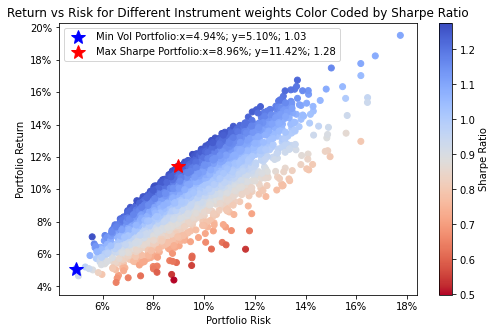

In [31]:
# Plot the min vol and max Sharpe portfolio
efficent_frontier_plot(prets, pvols)

 Mark the minimum vol portfolio with a blue star. Present the weights of this portfolio and rationalize the weight vector, i.e., give a plausible explanation for that choice of weights. Note down the risk, return and Sharpe of this portfolio.
 
**The weight vector associated with the Minimum volume portfolio is [0.02228058 0.04103796 0.22833789 0.18335454 0.28767587 0.07081066 0.04153957 0.12496294] (calculated above). We obseverd that we have the highest weights associated with EUR,BOND, SPY and GOLD and from the summary statistics we know that these instruments have lower risk associated with them. This is the reason for the choice of the weights in Min Volume portfolio.**

**The Portfolio risk is 4.94%, the portfolio Return is 5.10% and the sharpe ratio is 1.03**.

Mark the maximum Sharpe portfolio with a red star. Present the weights of this portfolio and rationalize the weight vector, i.e., give a plausible explanation for that choice of weights. Note down the risk, return and Sharpe of this portfolio.

**Max Sharpe Portfolio Weights:[0.20906911 0.09258164 0.03466735 0.09867297 0.23694407 0.05273158
 0.04299552 0.23233776](calculated above).For the max portfolio weights, the weights are mostly allocated to the instrument (Apple) with the highest expected returns and to the instrument with the least risk (BOND) since the weight distribution is trying to achieve an optimized Sharpe for the portfolio. Since the mean-variance tries to compute the optimal portfolio weights based on their preferred level of risk.**
 
**The Portfolio risk is 8.96%, the portfolio return is 11.42% and the Sharpe ratio is 1.28**.


### Equal Weighted Portfolio 

In [32]:
# Generating an equal weight array
weights = [0.125]*8
weights = np.array(weights)
weights

array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125])

In [33]:
equ_wtd_port = pd.DataFrame((weights*df_portfolio).sum(axis=1),columns=['equal weighted port'])

In [34]:
calc_summary_stats(equ_wtd_port)

,equal weighted port
Average Annual Return,10.04%
Annual Risk,8.58%
Sharpe Ratio,1.170235
maxDD,-19.87%
Success Ratio,54.55%


**Sharpe Ratio of equal weighted portfolio is 1.17 which is less than 1.28, the Sharpe ratio for Max Sharpe portfolio**.

### Beta Calculation for Max Sharpe Portfolio

**Beta's of securities is calculated against the benchmark, which is often "the market," i.e., the S&P 500**

In [35]:
# using max_sharpe_weights calculated above
max_wtd_port = pd.DataFrame((max_sharpe_weights*df_portfolio).sum(axis=1),columns=['Port'])
df_portfolio = df_portfolio.join(max_wtd_port, how= 'inner')


In [36]:
df_portfolio.head()

,AAPL,AMZN,EUR,SPY,BOND,ATT,INTC,GOLD,Port
2000-11-13,0.0,-0.0,-0.0,-0.0,0.000000,-0.015201,0.0,-0.001512,-0.001153
2000-11-14,0.0,0.0,0.0,0.0,0.000646,0.011924,0.0,0.001134,0.001045
2000-11-15,-0.0,0.0,-0.0,0.0,0.001475,-0.000000,0.0,0.001322,0.000657
2000-11-16,-0.0,-0.0,-0.0,-0.0,0.001218,-0.013001,-0.0,0.005644,0.000915
2000-11-17,-0.0,-0.0,-0.0,-0.0,-0.001612,0.036168,0.0,-0.002818,0.000871


In [37]:
port_Reg = LinearRegression().fit(df_portfolio[['SPY']], df_portfolio['Port'])

In [38]:
port_Reg.intercept_

0.000345994425717673

In [39]:
port_beta = port_Reg.coef_
print ('The beta for the Max Sharpe Portfolio is: {0:.3f}'.format(port_beta[0]))

The beta for the Max Sharpe Portfolio is: 0.420


In [40]:
port_Predicted = port_Reg.predict(df_portfolio[['SPY']])

In [41]:
# the r-squared of the fit
port_r2 = port_Reg.score(df_portfolio[['SPY']], df_portfolio['Port'])

Text(-0.01, -0.035, 'Linear Fit:y=+0.000346 +0.420481x\nR-squared: 0.248761')

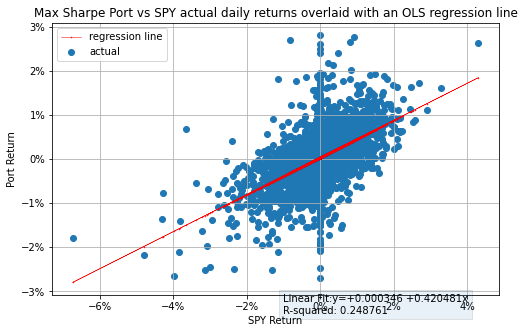

In [42]:
# plotting the scatter plot and overlaying it with the regression line
plt.figure(figsize=aspect_ratio)
ax = plt.subplot()
plt.scatter(df_portfolio['SPY'], df_portfolio['Port'], marker='o', label='actual')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.title('Max Sharpe Port vs SPY actual daily returns overlaid with an OLS regression line')
plt.xlabel('SPY Return')
plt.ylabel('Port Return')
plt.plot(df_portfolio['SPY'], port_Predicted, marker='.', c='r', markersize=1.0, lw=0.5, label='regression line')
plt.legend()
plt.grid()
plt.text(-0.01, -0.035, 'Linear Fit:y={:+.6f} {:+.6f}x\nR-squared: {:.6f}'.format(port_Reg.intercept_, port_Reg.coef_[0], port_r2), bbox = dict(alpha=0.1))

### Mean Variance for Frame with Benchmark/base-case Instruments

In [43]:
prets,pvols = mean_variace_optimizer(logReturns)
min_vol_weights, max_sharpe_weights  = weight_calculation(logReturns, prets, pvols)

Minimum Volume Portfolio Weights: [0.01363211 0.02864231 0.01890101 0.0085588  0.0535891  0.30046933
 0.27979313 0.29641421]
Max Sharpe Portfolio Weights: [0.24994123 0.02908779 0.09147803 0.02372614 0.01549256 0.11244263
 0.468526   0.00930562]


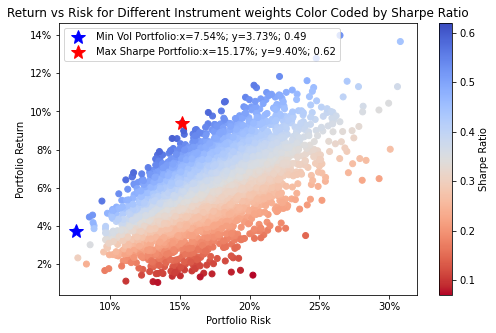

In [44]:
efficent_frontier_plot(prets, pvols)

### Mean Variance for Frame with MA Stratergy for all Instruments

In [45]:
prets,pvols = mean_variace_optimizer(df_ma_return_cal)
min_vol_weights, max_sharpe_weights  = weight_calculation(df_ma_return_cal, prets, pvols)

Minimum Volume Portfolio Weights: [0.00672607 0.0592206  0.12545184 0.10447407 0.25381526 0.20698326
 0.02042717 0.04152291 0.00694931 0.03611322 0.1383163 ]
Max Sharpe Portfolio Weights: [0.21330744 0.10204319 0.05084181 0.02819197 0.13007315 0.03237864
 0.0401095  0.20864195 0.00639097 0.04093946 0.14708191]


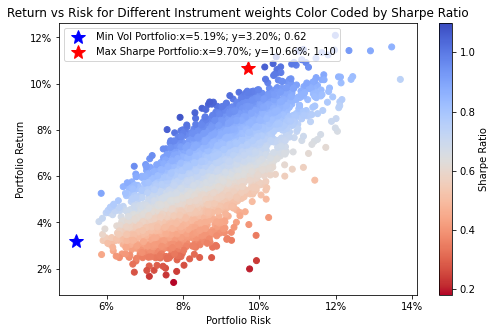

In [46]:
efficent_frontier_plot(prets, pvols)

### Frame with BB Strategy for all Instruments

In [47]:
prets,pvols = mean_variace_optimizer(df_bb_return)
min_vol_weights, max_sharpe_weights  = weight_calculation(df_bb_return, prets, pvols)

Minimum Volume Portfolio Weights: [0.03172452 0.00546005 0.0425072  0.20067603 0.20068519 0.13324582
 0.08223869 0.19890777 0.04808006 0.03448032 0.02199434]
Max Sharpe Portfolio Weights: [0.00984954 0.13513927 0.12667969 0.13041149 0.016487   0.01535758
 0.01751823 0.21157932 0.17339008 0.03934036 0.12424745]


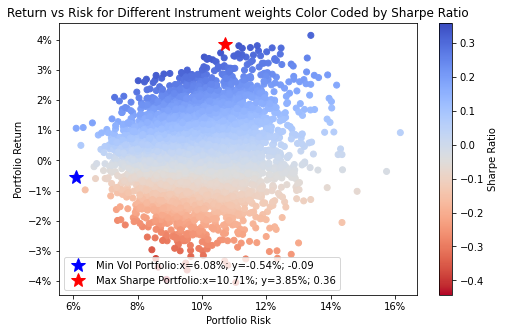

In [48]:
efficent_frontier_plot(prets, pvols)

**No, none of the above portfolios outperform our best portfolio. The best portfolio in our case has the max Sharpe of 1.28 while the portfolios generated by LogReturns, MA strategy  and BB strategy have lower Sharpe of 0.62, 1.10 and 0.36 respectively.** 

### Summary Statistics for the Portfolio

In [49]:
calc_summary_stats(df_portfolio)

,AAPL,AMZN,EUR,SPY,BOND,ATT,INTC,GOLD,Port
Average Annual Return,27.95%,21.96%,2.06%,5.78%,0.91%,4.52%,8.08%,9.06%,11.42%
Annual Risk,27.45%,33.10%,7.16%,10.63%,2.94%,19.25%,25.56%,17.92%,8.96%
Sharpe Ratio,1.018273,0.663285,0.288243,0.543433,0.308136,0.234605,0.316086,0.505877,1.275108
maxDD,-56.05%,-54.72%,-22.97%,-19.50%,-9.13%,-39.89%,-45.75%,-59.07%,-21.56%
Success Ratio,65.91%,66.88%,71.56%,69.58%,71.25%,74.50%,74.57%,53.00%,54.68%


- The Sharpe Ratio for our portfolio stands 1.28 which is higher than all other instruments. 
- The Average Annual Return for the constructed portfolio is 11.42% which is higher than all other instrument expect Apple and Amazon.
- Since Apple, Amazon have a high positive correlation, this means that their respective prices tend to move in the same direction and therefore adding them to the portfolio would increase the level of systematic risk despite the sharpe increases.
- Risk of our portfolio is low and similar to EUR while the Return is good leading to a higher Sharpe Ratio.
- Though the Success Ratio is low we have a low risk and low max DD so this does not harm our portfolio.

**"We pledge on our honor that we have not given nor received any unauthorized assistance on this assignment with other groups."**
- Chi-Hao Tseng, Hanyu Li, Raghul Pandi, Shubhangkar Girish Jain, Tanvi Mehra.